In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, Conv1D, MaxPooling1D, BatchNormalization, LeakyReLU, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# check tensorflow version
print(tf.__version__)

# If a GPU is available, this should print a device name that includes "Metal"
print(tf.config.list_physical_devices('GPU'))

# verify tensorflow sees all GPUs available on my M1 Max
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [2]:
# read in json data file
df = pd.read_json("data/prompts.json")

# create a dataframe of length = 5000 based on the column label = code
categories = ['code', 'language', 'math']
df_dict = {}
for category in categories:
    df_dict[category] = df[df['label'] == category].head(5000)  # assuming each category has at least 5000 entries
    print(f'Shape of df_{category}: {df_dict[category].shape}')

# Concatenate the data from all categories
X = pd.concat(df_dict.values())

# Assuming that 'instruction' is the name of the column containing the text data
y = X['label']

# Split the data into training and testing sets (80% for training and 20% for testing)
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X['instruction'], y, test_size=0.2, random_state=42)

# Split the training set into training and validation sets (70% for training and 30% for validation)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, test_size=0.3, random_state=42)

# Tokenize the input sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_validate_seq = tokenizer.texts_to_sequences(X_validate)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to a fixed length
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_validate_pad = pad_sequences(X_validate_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Create a label encoder object
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = to_categorical(encoder.transform(y_train))
y_validate_encoded = to_categorical(encoder.transform(y_validate))
y_test_encoded = to_categorical(encoder.transform(y_test))

Shape of df_code: (5000, 4)
Shape of df_language: (5000, 4)
Shape of df_math: (5000, 4)


** Build and evaluate the Model

2024-04-09 12:15:04.669439: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-04-09 12:15:04.669462: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-04-09 12:15:04.669468: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-04-09 12:15:04.669501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-09 12:15:04.669518: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/40


2024-04-09 12:15:05.782171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 13s 84ms/step - loss: 5.1546 - accuracy: 0.4238 - val_loss: 3.7825 - val_accuracy: 0.3342 - lr: 0.0010
Epoch 2/40
132/132 [==============================] - 10s 76ms/step - loss: 2.6993 - accuracy: 0.6390 - val_loss: 3.1065 - val_accuracy: 0.3342 - lr: 0.0010
Epoch 3/40
132/132 [==============================] - 10s 76ms/step - loss: 1.6173 - accuracy: 0.8280 - val_loss: 2.5433 - val_accuracy: 0.3344 - lr: 0.0010
Epoch 4/40
132/132 [==============================] - 10s 77ms/step - loss: 1.0254 - accuracy: 0.8873 - val_loss: 1.9312 - val_accuracy: 0.3467 - lr: 0.0010
Epoch 5/40
132/132 [==============================] - 10s 77ms/step - loss: 0.6995 - accuracy: 0.9115 - val_loss: 1.0870 - val_accuracy: 0.6686 - lr: 0.0010
Epoch 6/40
132/132 [==============================] - 10s 76ms/step - loss: 0.5148 - accuracy: 0.9214 - val_loss: 0.7200 - val_accuracy: 0.8253 - lr: 0.0010
Epoch 7/40
132/132 [==============================] - 10s 76ms/step -

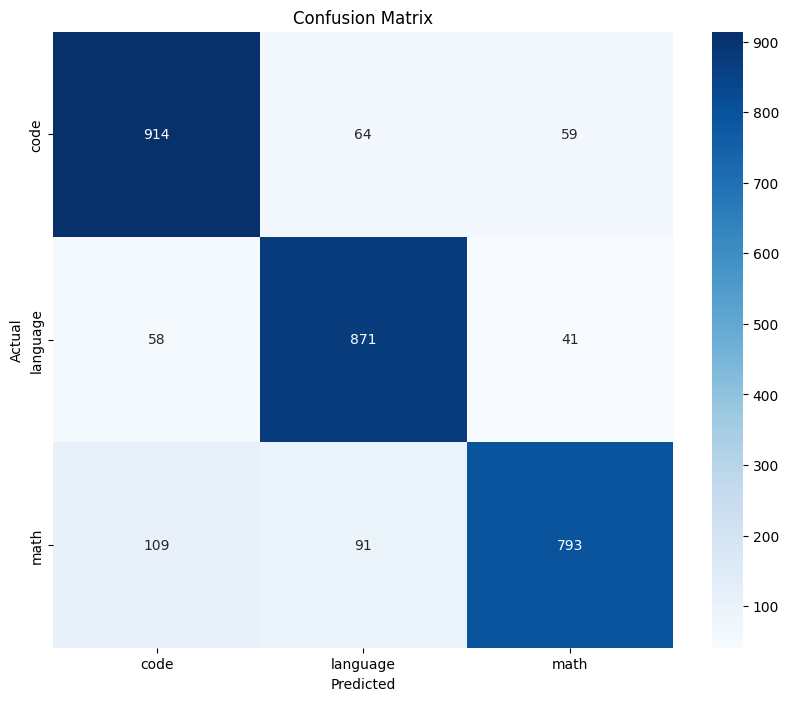

In [3]:
# Define the model with adjusted regularization and learning rate scheduler
def create_model(input_shape, num_classes):

    model = Sequential([
        #input layer
        Embedding(input_dim=10000, output_dim=128, input_length=input_shape),
        #first convolutional layer
        Conv1D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.55),
        #second convolutional layer
        Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.55),
        #Flatten the output
        Flatten(),
        #first dense layer
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        #LeakyReLU(alpha=0.1),
        Dropout(0.55),
        #output layer
        Dense(num_classes, activation='softmax')
    ])
    return model

# Adjustments to the training routine
model = create_model(max_len, len(encoder.classes_))
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(
    X_train_pad, 
    y_train_encoded, 
    validation_data=(X_validate_pad, y_validate_encoded), 
    epochs=40, 
    batch_size=64, 
    callbacks=[early_stopping, lr_schedule]
)

# Evaluate the model
def evaluate_model(model, X, y, label_names):
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y, axis=1)
    print(classification_report(true_classes, predicted_classes, target_names=label_names))
    confusion_mtx = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Validate model performance
class_names = encoder.classes_
evaluate_model(model, X_test_pad, y_test_encoded, class_names)

** Test the output

In [4]:
# Function to preprocess and predict the category of a new prompt
def classify_prompt(prompt, tokenizer, model, max_len, label_encoder):
    # Tokenize the prompt
    seq = tokenizer.texts_to_sequences([prompt])
    # Pad the sequence
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    # Predict the category
    prediction = model.predict(padded)
    # Get the class index
    predicted_class_index = np.argmax(prediction, axis=1)
    # Decode the class index to the actual class name
    predicted_class = label_encoder.inverse_transform(predicted_class_index)
    return predicted_class

# Example prompt
prompt = "explain psycopathy"

# Classifying the prompt
predicted_category = classify_prompt(prompt, tokenizer, model, max_len, encoder)
print("The predicted category for the prompt is:", predicted_category[0])


1/1 [==============================] - 0s 88ms/step
The predicted category for the prompt is: language


** Save and generalize the model

In [5]:
model.save('model2.h5')

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
